In [1]:
# imports
# general
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import dot 
from sklearn.metrics import accuracy_score
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
# lime
import lime
import lime.lime_tabular
# advertorch 
from advertorch.attacks import LinfPGDAttack
# net classes
from nets_test import Net,CNet
# cpu / gpu
if torch.cuda.is_available():  
    device = 'cuda:0'
else:  
    device = 'cpu'
print('device: ', device)

# functions 
def train_models(architectures,net_class,data_train,data_test):
    for i,layers in enumerate(architectures):
        for j in range(4):
            print('------------------------------------------------------------')
            print(str(net_class),'| ARCHITECTURE ',i,' | MODEL ', j)
            net= net_class(layers,net_num=j,dev=device)
            net.train(data_train, n_epochs=50)
            net.accuracy(data_test)
            net.summary()
    return True 
            
def load_models(architectures,net_class):
    nets = []
    for i,layers in enumerate(architectures):
        for j in range(4):
            net = net_class(layers,net_num=j,dev=device)
            net.load()
            nets.append(net)
    return nets

device:  cuda:0


In [2]:
# obtain mnist data and process
batch_size = 128

dataset = MNIST('.', train=True, download=False,transform=transforms.ToTensor())
dataset_test = MNIST('.', train=False, download=False,transform=transforms.ToTensor())

train1, train2 = random_split(dataset,[30000,30000])#DataLoader(dataset, batch_size=batch_size)
data_loader_train1 = DataLoader(train1, batch_size=batch_size)
data_loader_train2 = DataLoader(train2, batch_size=batch_size)
data_loader_train_full = DataLoader(dataset, batch_size=batch_size)
data_loader_test = DataLoader(dataset_test, batch_size=1000)

In [3]:
architectures_dnn = [[784,256,128,64],
                    [784,256,128,64,32],
                    [784,868,256,32],
                    [784,1000,256]]

architectures_cnn = [[(1,2,2,1),(2,3,2,1),(3,4,1,1)],
                    [(1,3,2,1),(3,4,2,1)],
                    [(1,2,3,3),(2,3,3,3)],
                    [(1,2,3,3),(2,3,3,3),(3,4,1,1)]]

In [ ]:
%%time 
# train models
# feed forward
#train_models(architectures_dnn,Net,data_loader_train1,data_loader_test)

# convolutional
train_models(architectures_cnn,CNet,data_loader_train1,data_loader_test)

In [4]:
# load models 
nets_dnn = load_models(architectures_dnn,Net)
nets_cnn = load_models(architectures_cnn,CNet)

model loaded from  ./models/network0_[784, 256, 128, 64].pth !
model loaded from  ./models/network1_[784, 256, 128, 64].pth !
model loaded from  ./models/network2_[784, 256, 128, 64].pth !
model loaded from  ./models/network3_[784, 256, 128, 64].pth !
model loaded from  ./models/network0_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network1_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network2_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network3_[784, 256, 128, 64, 32].pth !
model loaded from  ./models/network0_[784, 868, 256, 32].pth !
model loaded from  ./models/network1_[784, 868, 256, 32].pth !
model loaded from  ./models/network2_[784, 868, 256, 32].pth !
model loaded from  ./models/network3_[784, 868, 256, 32].pth !
model loaded from  ./models/network0_[784, 1000, 256].pth !
model loaded from  ./models/network1_[784, 1000, 256].pth !
model loaded from  ./models/network2_[784, 1000, 256].pth !
model loaded from  ./models/network3_[784, 1000,

In [7]:
# set up for lime
x_train = dataset.data.float().to(device)
y_train = dataset.targets.float().to(device)
x_test = dataset_test.data.float().to(device)
y_test = dataset_test.targets.float().to(device)

f_names = np.arange(0,28*28) 
c_names = ['0','1','2','3','4','5','6','7','8','9']

class DNN_model_wrap():
    def __init__(self,model,dev='cpu'):
        self.model = model
        self.dev = dev
    
    def predict_proba(self,x):
        try:
            x = torch.from_numpy(x).float().to(self.dev)
        except:
            x = x.float().to(self.dev)
        try:
            output = self.model(x).cpu().detach().numpy()
        except:
            output = self.model(x)
        return output
    
class CNN_model_wrap():
    def __init__(self,model,dev='cpu'):
        self.model = model
        self.dev = dev
    
    def predict_proba(self,x):
        try:
            x = torch.from_numpy(x).float().to(self.dev)
            x = x.reshape(x.shape[0],1,28,28)
        except:
            x = x.float().to(self.dev)
            x = x.reshape(x.shape[0],1,28,28)
        try:
            output = self.model(x).cpu().detach().numpy()
        except:
            output = self.model(x)
        return output
        
def make_exp_vec(exp):
    """
    Takes a LIME explanation which is a dictionary (i, w(i)) where i is the feature id and w(i) is the weight 
    of the ith feature. With the explanation vector we generate, we can 
    Arg - 
        exp: LIME explanation
    Returns - 
        v: explanation vector where v[i] = w(i)
        y_pred: the prediction of the model
    """
    k = list(exp.keys())[0]
    l = exp[k]
    v = np.zeros(len(l))
    for (i,w) in l:
        v[i] = w
    y_pred = k
    return v,y_pred

def exp_point(point,X,model,f_names,c_names):
    """
    The explanation vector for top label of a point in a certain data set.
    Arg - 
        point: point to explain
        X: data model was trained on
        model: black box
        f_names: names of features
        c_names: names of classes
    Returns - 
        v: explanation vector (see make_exp_vec())
        y_pred: model prediction
    """
    explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=f_names, class_names=c_names, discretize_continuous=False)
    exp = explainer.explain_instance(point, model, num_features=len(point), top_labels=1)
    v,y_pred = make_exp_vec(exp.local_exp)
    return v, y_pred

def cos_sim(v,w):
    """
    Computes the cosine similarity between two vectors.
    Arg - 
        v: numpy array like a vector
        w: numpy array like a vector
    Returns - 
        sim: cosine similarity of the two vectors
    """
    return np.dot(v,w)/(norm(v)*norm(w))

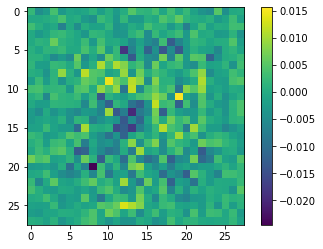

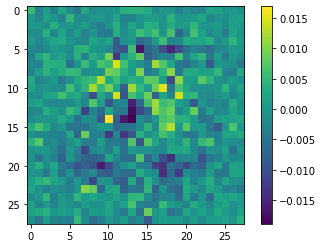

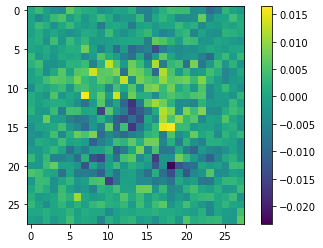

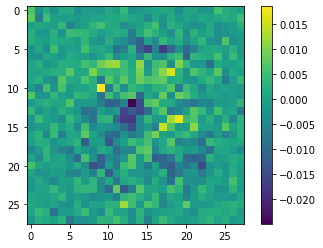

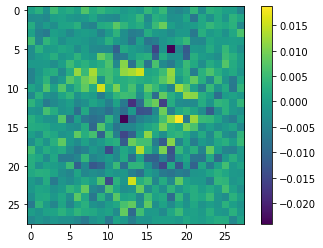

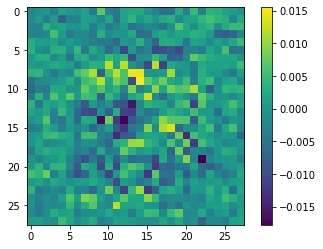

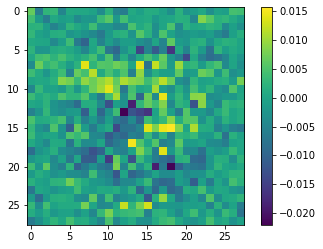

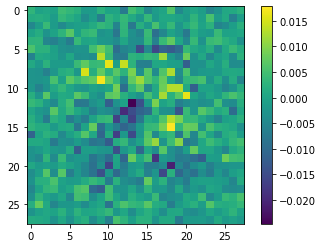

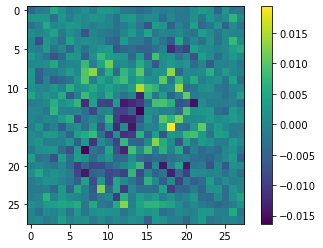

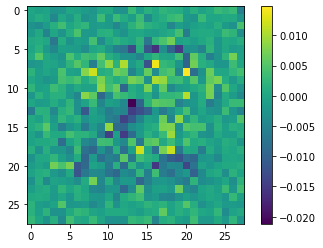

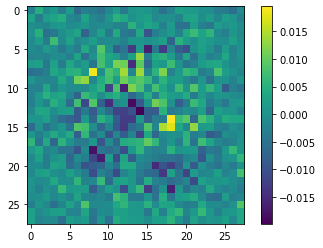

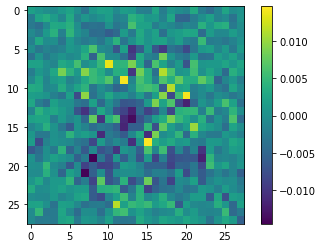

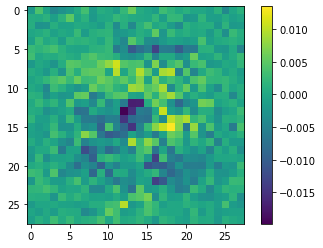

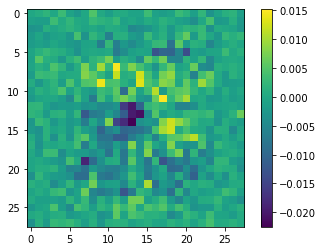

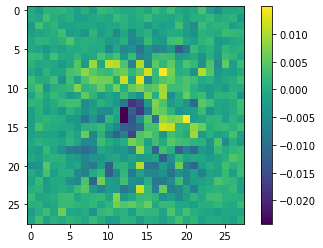

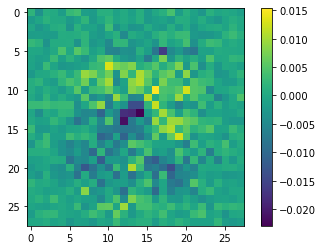

In [8]:
point_exp = x_test[0].reshape(28*28,).cpu().detach().numpy()
tr_data = x_train.reshape(x_train.shape[0],28*28).cpu().detach().numpy()

exp_vecs = []
for i,net in enumerate(nets_dnn):
    model = DNN_model_wrap(net,dev=device).predict_proba
    v,y_pred = exp_point(point_exp,tr_data,model,f_names,c_names)
    exp_vecs.append(v)
    plt.figure(i)
    plt.imshow(v.reshape(28,28))
    plt.colorbar()
    plt.show()

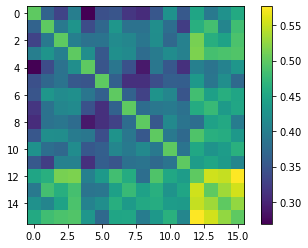

In [9]:
sim_matrix = 0.5*np.ones((16,16))
for i,vec1 in enumerate(exp_vecs):
    for j,vec2 in enumerate(exp_vecs):
        if i == j:
            pass
        else:
            sim_matrix[i,j] = cos_sim(vec1,vec2)
        
plt.figure()
plt.imshow(sim_matrix)
plt.colorbar()
plt.show()

In [14]:
# attack each 

'''
1. generate explanations for each data point (num_models x num_points)
2. generate adv examples for each point (num_models x num_points)
3. plot x = average similarity and y = transferability
'''

point_exps = x_test[0:20].reshape(-1,28*28).cpu().detach().numpy()
points_attack = x_test[0:20].reshape(-1,28*28)
#points_attack = points_attack.reshape(points_attack.shape[0],1,28,28)
labels = y_test[0:20]
all_exps = []
adv_examps = []
for i,net in enumerate(nets_dnn):
    adversary_LinfPGD = LinfPGDAttack(
        net, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
        nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
        targeted=False)
    pgd_advex = adversary_LinfPGD.perturb(points_attack)
    adv_examps.append(pgd_advex.cpu().detach().numpy())
    model = DNN_model_wrap(net,dev=device).predict_proba
    exps = []
    for point in point_exps:
        v,y_pred = exp_point(point_exp,tr_data,model,f_names,c_names)
        exps.append(v)
    all_exps.append(exps)

all_exps = np.array(all_exps)
adv_examps = np.array(adv_examps)

print(all_exps.shape)
print(adv_examps.shape)

(16, 20, 784)
(16, 20, 784)


In [15]:
np.save('./all_explanations.npy',all_exps)
np.save('./all_advexamples.npy',adv_examps)

In [40]:
for i,(net1,exps1,advs1) in enumerate(zip(nets_dnn,all_exps,adv_examps)):
    for j,(net2,exps2,advs2) in enumerate(zip(nets_dnn,all_exps,adv_examps)):
        if i>j or i==j:
            pass
        else:
            out1 = torch.argmax(net1(torch.from_numpy(advs1).to(device)),dim=1)
            out2 = torch.argmax(net2(torch.from_numpy(advs1).to(device)),dim=1)
            mask = (out1 != labels)&(out2 != labels)
            robust_advs = torch.from_numpy(advs1).to(device)[mask]
            new_lbl = labels[mask]
            if robust_advs.shape[0] > 1 :
                print(torch.argmax(net2(robust_advs),dim=1))
                print(torch.argmax(net1(robust_advs),dim=1))
                print(new_lbl)
                print('-----------------------------------')

            else:
                pass
                

            

tensor([9, 0], device='cuda:0')
tensor([7, 0], device='cuda:0')
tensor([9., 5.], device='cuda:0')
-----------------------------------
tensor([9, 6, 8], device='cuda:0')
tensor([7, 2, 8], device='cuda:0')
tensor([9., 5., 3.], device='cuda:0')
-----------------------------------
tensor([9, 0, 8], device='cuda:0')
tensor([7, 2, 8], device='cuda:0')
tensor([9., 5., 3.], device='cuda:0')
-----------------------------------
tensor([4, 8, 3], device='cuda:0')
tensor([7, 6, 8], device='cuda:0')
tensor([4., 5., 3.], device='cuda:0')
-----------------------------------
tensor([3, 0], device='cuda:0')
tensor([3, 2], device='cuda:0')
tensor([4., 5.], device='cuda:0')
-----------------------------------
tensor([4, 5, 8], device='cuda:0')
tensor([7, 2, 8], device='cuda:0')
tensor([9., 5., 3.], device='cuda:0')
-----------------------------------
tensor([9, 6, 3], device='cuda:0')
tensor([7, 2, 8], device='cuda:0')
tensor([9., 5., 3.], device='cuda:0')
-----------------------------------
tensor([6, 9

In [ ]:
sim = []
transf = []
amnt_adv = []

for i,(net1,exps1,advs1) in enumerate(zip(nets,all_exps,adv_examps)):
    for j,(net2,exps2,advs2) in enumerate(zip(nets,all_exps,adv_examps)):
        if i > j:
            pass
        else:
            sim.append((1./exps1.shape[0])*norm(exps1-exps2,'fro'))
            out1 = torch.argmax(net1(torch.from_numpy(advs1).to(device)),dim=1)
            amnt_adv.append(1.-accuracy_score(out1.cpu().detach().numpy(),labels.cpu().detach().numpy()))
            tr_net1 = torch.from_numpy(advs1).to(device)[out1 != labels]
            tr_lbl = labels[out1 != labels]
            out2 = torch.argmax(net2(tr_net1),dim=1)
            transf.append(1.-accuracy_score(out2.cpu().detach().numpy(),tr_lbl.cpu().detach().numpy()))

In [ ]:
plt.figure(1,[5,5])
plt.scatter(sim,transf,color='tab:blue',label='% transfer')
plt.scatter(sim,amnt_adv,color='tab:red',label='% adv')
plt.xlabel('explanation similarity')
plt.ylabel('% adv')
plt.legend()#loc=3)
plt.show()

In [ ]:
'''
for net1 in nets:
    for net2 in nets:
        generate adv examples for net1 (y1)
        run them through net2 (y2)
        generate exp1,exp2 explanations for each net1,net2
        y1,y2,exp1,exp2
        if y1,y2 both trick, take note of sim(exp1,exp2)
        
build histogram? other type of plot? 

'''

In [33]:
img = torch.rand(1,784).to(device)
net1(img)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])

In [58]:
net = nets_dnn[0]
point_exps = x_test[0:500].reshape(-1,28*28).cpu().detach().numpy()
adversary_LinfPGD = LinfPGDAttack(
        net, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
        nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
        targeted=False)
pgd_advex = adversary_LinfPGD.perturb(points_attack)
adv_examps = pgd_advex.cpu().detach().numpy()
model = DNN_model_wrap(net,dev=device).predict_proba
exps = []
for point in point_exps:
    v,y_pred = exp_point(point_exp,tr_data,model,f_names,c_names)
    exps.append(v)


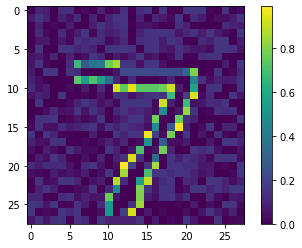

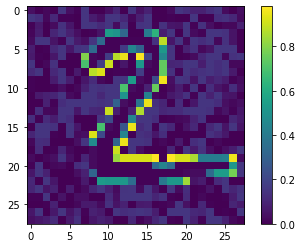

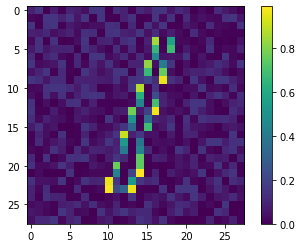

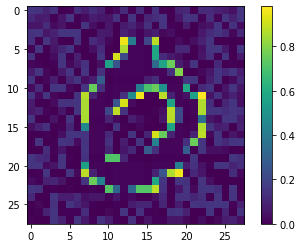

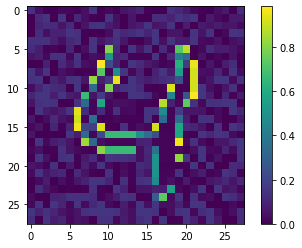

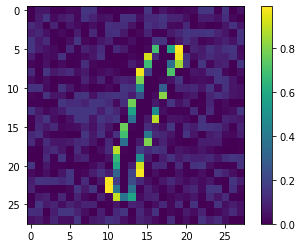

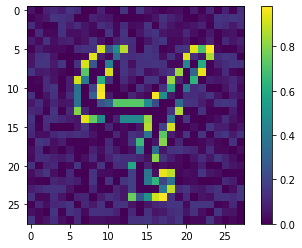

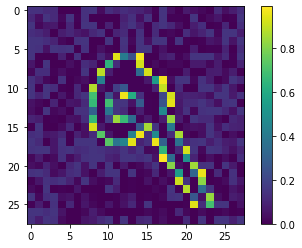

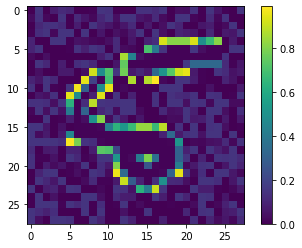

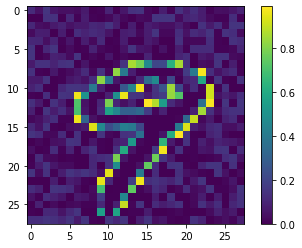

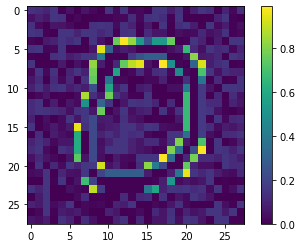

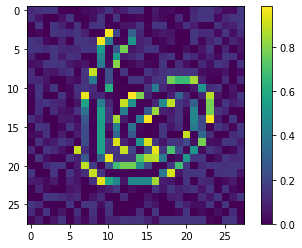

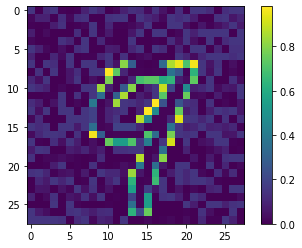

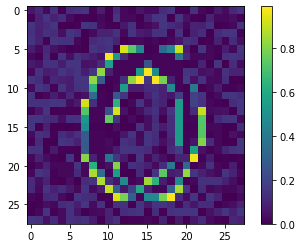

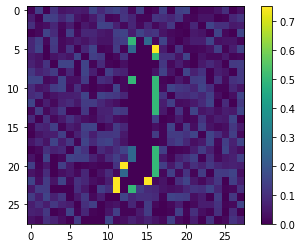

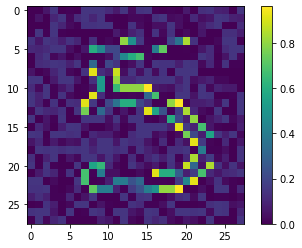

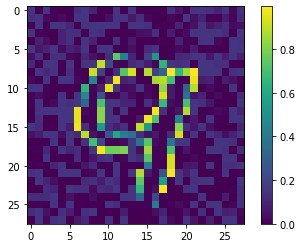

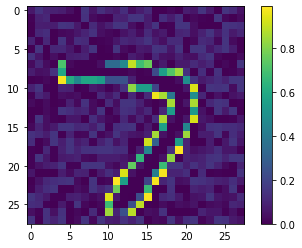

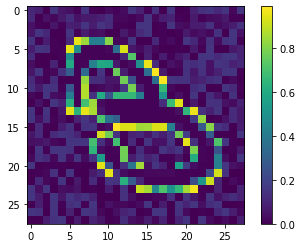

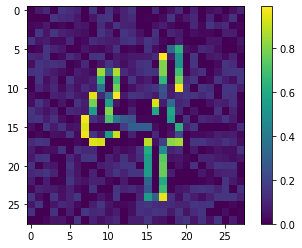

In [88]:
exps = np.array(exps)
adv_perts = (pgd_advex-points_attack/255.).detach().cpu().numpy()
for adv in adv_perts:
    plt.figure()
    plt.imshow(adv.reshape(28,28))
    plt.colorbar()
    plt.show()

In [83]:
sim = []
for exp,adv in zi+p(exps,adv_perts):
    sim.append(cos_sim(exp,adv))

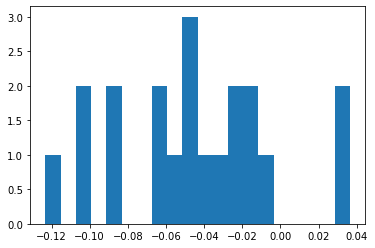

In [84]:
plt.figure()
plt.hist(sim,20)
plt.show()

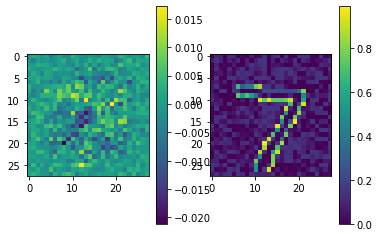

similairty:  -0.023689845982810345
------------------------------------


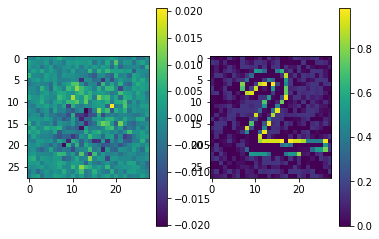

similairty:  -0.12321876570847758
------------------------------------


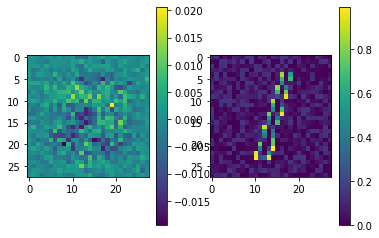

similairty:  -0.08926140295266385
------------------------------------


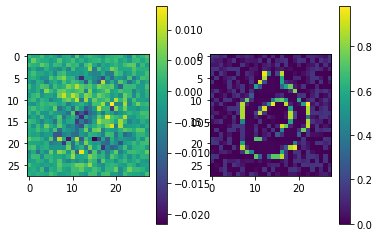

similairty:  -0.013627327494960166
------------------------------------


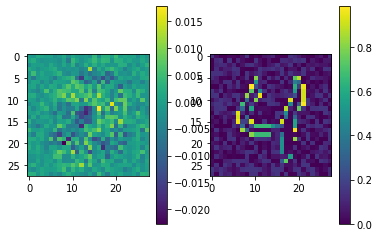

similairty:  -0.06507373235443843
------------------------------------


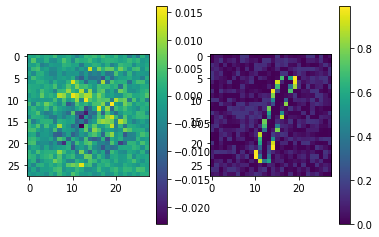

similairty:  -0.05244413039740406
------------------------------------


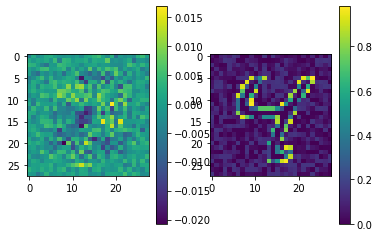

similairty:  -0.0843828339325317
------------------------------------


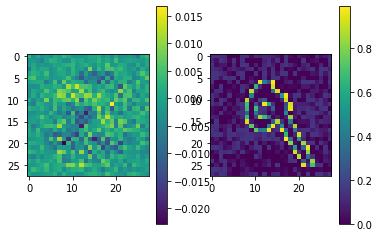

similairty:  -0.04607761604154503
------------------------------------


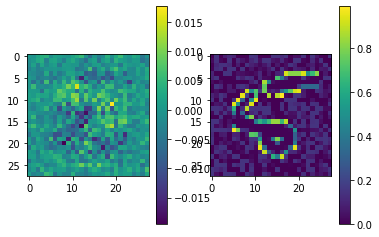

similairty:  -0.04825531428803642
------------------------------------


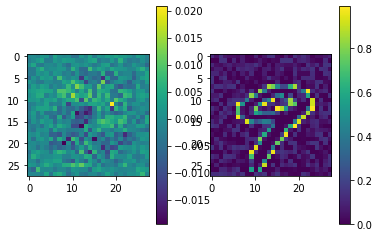

similairty:  -0.018875317230399848
------------------------------------


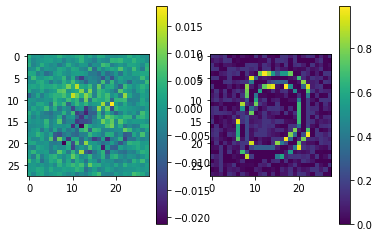

similairty:  -0.06178301772391021
------------------------------------


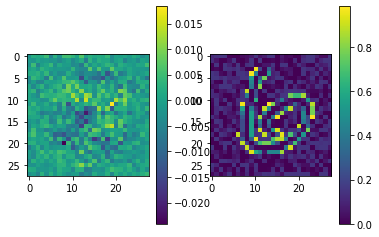

similairty:  -0.102426857611122
------------------------------------


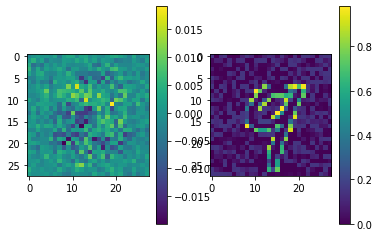

similairty:  0.033208222106527366
------------------------------------


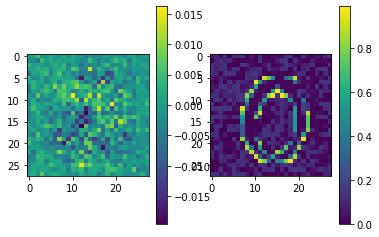

similairty:  0.03639397641848249
------------------------------------


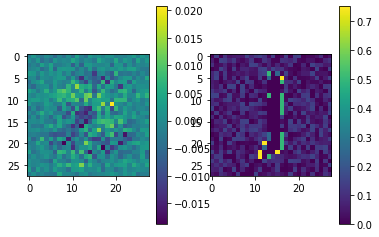

similairty:  -0.03393066950985624
------------------------------------


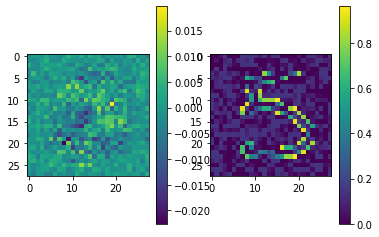

similairty:  -0.03734322528000906
------------------------------------


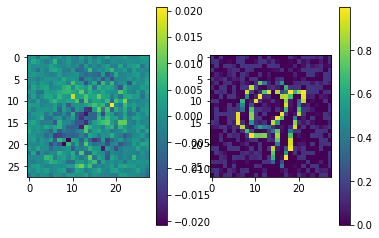

similairty:  -0.045363409033818164
------------------------------------


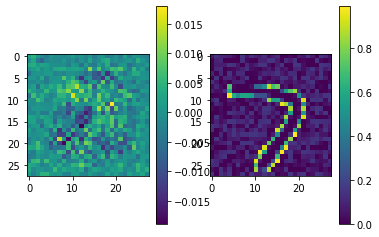

similairty:  -0.023533986149619768
------------------------------------


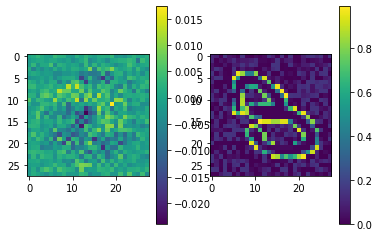

similairty:  -0.10383331117308732
------------------------------------


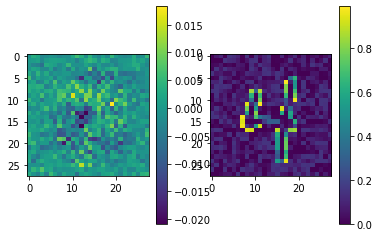

similairty:  -0.003814382865810466
------------------------------------


In [86]:
for i,(exp,adv) in enumerate(zip(exps,adv_perts)):
    sim.append(cos_sim(exp,adv))
    plt.figure(i)
    plt.subplot(1, 2, 1)
    plt.imshow(exp.reshape(28,28))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(adv.reshape(28,28))
    plt.colorbar()
    plt.show()
    print('similairty: ', sim[i])
    print('------------------------------------')